In [9]:
# Required Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Load CSV file
data = pd.read_csv('train.csv')

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Select relevant columns
data = data[['building_id', 'meter', 'timestamp', 'meter_reading']]

# Normalize meter_reading
scaler = MinMaxScaler()
data['meter_reading'] = scaler.fit_transform(data[['meter_reading']])

# Group by building_id and meter to create time series
grouped = data.groupby(['building_id', 'meter'])

# Create sequences of time series data
def create_sequences(group, sequence_length=24):
    sequences = []
    for i in range(len(group) - sequence_length):
        seq = group['meter_reading'].iloc[i:i+sequence_length].values
        sequences.append(seq)
    return np.array(sequences)

# Generate sequences
sequences_list = []
for _, group in grouped:
    seq = create_sequences(group)
    if len(seq) > 0:
        sequences_list.append(seq)

# Check if sequences_list is empty or has inconsistent shapes
if len(sequences_list) > 0:
    # Ensure sequences have consistent shapes
    sequence_lengths = [seq.shape[1] for seq in sequences_list if len(seq) > 0]

    # Stack sequences only if they are consistent
    if len(set(sequence_lengths)) == 1:
        sequences = np.vstack(sequences_list)
    else:
        sequences = np.concatenate(sequences_list, axis=0)

# Check if sequences are successfully generated
if len(sequences) == 0:
    raise ValueError("No valid sequences generated. Check input data and sequence length.")

print(f"Generated {len(sequences)} sequences of shape {sequences.shape}")

Generated 20158980 sequences of shape (20158980, 24)


Checking using Wasserstein distance and KS test

Epoch 0/200 | Generator Loss: -0.0017 | Discriminator Loss: 17.6076
Epoch 10/200 | Generator Loss: 0.0096 | Discriminator Loss: 15.8830
Epoch 20/200 | Generator Loss: -0.0066 | Discriminator Loss: 13.6447
Epoch 30/200 | Generator Loss: -0.2202 | Discriminator Loss: 11.1790
Epoch 40/200 | Generator Loss: -0.6867 | Discriminator Loss: 7.9996
Epoch 50/200 | Generator Loss: -1.6168 | Discriminator Loss: 5.8779
Epoch 60/200 | Generator Loss: -2.3065 | Discriminator Loss: 4.6071
Epoch 70/200 | Generator Loss: -2.4224 | Discriminator Loss: 4.9723
Epoch 80/200 | Generator Loss: -2.4123 | Discriminator Loss: 4.0919
Epoch 90/200 | Generator Loss: -1.3239 | Discriminator Loss: 2.5370
Epoch 100/200 | Generator Loss: 0.0572 | Discriminator Loss: 0.7037
Epoch 110/200 | Generator Loss: 0.8764 | Discriminator Loss: 0.0900
Epoch 120/200 | Generator Loss: 1.2899 | Discriminator Loss: -0.2524
Epoch 130/200 | Generator Loss: 1.3268 | Discriminator Loss: -0.5300
Epoch 140/200 | Generator Loss: 1.5244 | Dis

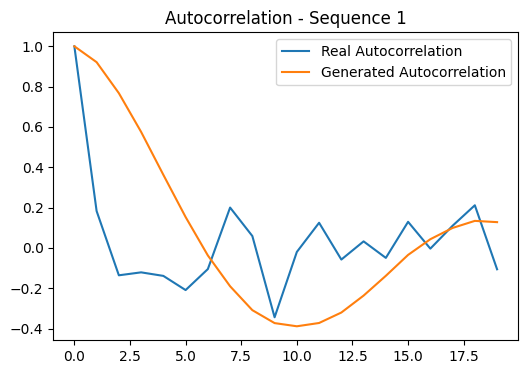

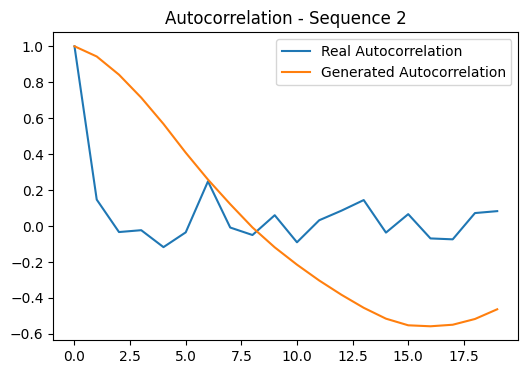

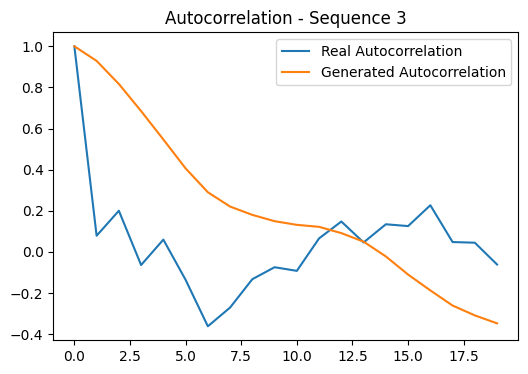

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# -------------------------------
# ✅ Define necessary parameters
# -------------------------------
batch_size = 32
seq_len = 48
latent_dim = 100
epochs = 200
learning_rate = 0.0002
gradient_penalty_weight = 18.0  # For WGAN-GP
noise_stddev = 0.01  # Noise standard deviation for discriminator input

# -------------------------------
# ✅ Enable eager execution
# -------------------------------
tf.config.run_functions_eagerly(True)

# -------------------------------
# ✅ Data Preprocessing: Normalize Sequences
# -------------------------------
def normalize_data(sequences):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    reshaped_data = sequences.reshape(-1, 1)
    scaled_data = scaler.fit_transform(reshaped_data)
    return scaled_data.reshape(sequences.shape), scaler

def inverse_transform(scaled_data, scaler):
    reshaped_data = scaled_data.reshape(-1, 1)
    return scaler.inverse_transform(reshaped_data).reshape(scaled_data.shape)

# Generate Dummy Sequence Data for Training
sequences = np.random.rand(1000, seq_len, 1).astype(np.float32)

# Normalize the sequences
sequences, scaler = normalize_data(sequences)

# -------------------------------
# ✅ Define Generator Model
# -------------------------------
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_len, latent_dim)),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='tanh'))
    ])
    return model

# -------------------------------
# ✅ Define Discriminator Model
# -------------------------------
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_len, 1)),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])
    return model

# -------------------------------
# ✅ Define Autoencoder for Latent Representation
# -------------------------------
def build_autoencoder():
    encoder_input = tf.keras.layers.Input(shape=(seq_len, 1))
    encoded = tf.keras.layers.LSTM(64, return_sequences=True)(encoder_input)
    encoded = tf.keras.layers.LSTM(32)(encoded)

    decoder_input = tf.keras.layers.RepeatVector(seq_len)(encoded)
    decoded = tf.keras.layers.LSTM(64, return_sequences=True)(decoder_input)
    decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoded)

    autoencoder = tf.keras.models.Model(inputs=encoder_input, outputs=decoded)
    encoder = tf.keras.models.Model(inputs=encoder_input, outputs=encoded)
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

# -------------------------------
# ✅ Define Loss Functions
# -------------------------------
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss

# Gradient penalty for WGAN-GP
def gradient_penalty(real_data, fake_data):
    alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_data + (1 - alpha) * fake_data

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# -------------------------------
# ✅ Build and Compile Models
# -------------------------------
generator = build_generator()
discriminator = build_discriminator()

# Build models for initial setup
_ = generator(tf.random.normal([1, seq_len, latent_dim]))
_ = discriminator(tf.random.normal([1, seq_len, 1]))

# -------------------------------
# ✅ Define Optimizers and Learning Rate Schedule
# -------------------------------
# Using RMSprop for WGAN
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate)

# -------------------------------
# ✅ Training Step
# -------------------------------
def add_noise_to_data(data, stddev):
    noise = tf.random.normal(shape=tf.shape(data), mean=0.0, stddev=stddev)
    return data + noise

def train_step(real_data):
    noise = tf.random.normal([batch_size, seq_len, latent_dim])

    # Generate synthetic sequences
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        # Add noise to discriminator inputs to prevent overfitting
        real_data_noisy = add_noise_to_data(real_data, noise_stddev)
        generated_data_noisy = add_noise_to_data(generated_data, noise_stddev)

        # Discriminator predictions
        real_output = discriminator(real_data_noisy, training=True)
        fake_output = discriminator(generated_data_noisy, training=True)

        # Calculate Losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Add Gradient Penalty
        gp = gradient_penalty(real_data, generated_data)
        disc_loss += gradient_penalty_weight * gp

    # Calculate Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply Gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# -------------------------------
# ✅ Training Loop
# -------------------------------
for epoch in range(epochs):
    idx = np.random.randint(0, len(sequences), batch_size)
    real_sequences = sequences[idx]
    real_sequences = tf.convert_to_tensor(real_sequences)

    # Train the model
    gen_loss, disc_loss = train_step(real_sequences)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} | Generator Loss: {gen_loss.numpy():.4f} | Discriminator Loss: {disc_loss.numpy():.4f}")

# -------------------------------
# ✅ Generate and Inverse Transform Sequences
# -------------------------------
num_samples_to_generate = 1000
noise = tf.random.normal([num_samples_to_generate, seq_len, latent_dim])
generated_sequences = generator(noise, training=False).numpy()

# Inverse transform to original scale
generated_sequences = inverse_transform(generated_sequences, scaler)

# -------------------------------
# ✅ Compute statistics for real and generated data
# -------------------------------
def compute_statistics(sequences):
    mean = np.mean(sequences, axis=(0, 1))
    std = np.std(sequences, axis=(0, 1))
    min_val = np.min(sequences, axis=(0, 1))
    max_val = np.max(sequences, axis=(0, 1))
    return mean, std, min_val, max_val

# Real data statistics
real_mean, real_std, real_min, real_max = compute_statistics(sequences)
generated_mean, generated_std, generated_min, generated_max = compute_statistics(generated_sequences)

print("Real Data Statistics:")
print(f"Mean: {float(real_mean.item()):.4f}, Std: {float(real_std.item()):.4f}, Min: {float(real_min.item()):.4f}, Max: {float(real_max.item()):.4f}")
print("\nGenerated Data Statistics:")
print(f"Mean: {float(generated_mean.item()):.4f}, Std: {float(generated_std.item()):.4f}, Min: {float(generated_min.item()):.4f}, Max: {float(generated_max.item()):.4f}")

# -------------------------------
# ✅ Define Autocorrelation Function
# -------------------------------
def autocorrelation(sequence):
    n = len(sequence)
    mean = np.mean(sequence)
    var = np.var(sequence)
    autocorr = np.correlate(sequence - mean, sequence - mean, mode="full") / (var * n)
    return autocorr[n - 1:]

# -------------------------------
# ✅ Sample real and generated sequences for autocorrelation comparison
# -------------------------------
num_samples_to_plot = 3
real_sequences_to_plot = inverse_transform(sequences[:num_samples_to_plot], scaler)
generated_sequences_to_plot = generated_sequences[:num_samples_to_plot]

# -------------------------------
# ✅ Compute and Plot Autocorrelation for Real and Generated Samples
# -------------------------------
for i in range(num_samples_to_plot):
    real_autocorr = autocorrelation(real_sequences_to_plot[i].squeeze())
    generated_autocorr = autocorrelation(generated_sequences_to_plot[i].squeeze())

    plt.figure(figsize=(6, 4))
    plt.plot(real_autocorr[:20], label="Real Autocorrelation")
    plt.plot(generated_autocorr[:20], label="Generated Autocorrelation")
    plt.title(f"Autocorrelation - Sequence {i + 1}")
    plt.legend()
    plt.show()